# Homework 1

Charles Xu

Due date: 4/11/2024

Hours spent: 10

In [75]:
import cvxpy as cp
import numpy as np
import matplotlib.pyplot as plt

## Problem 1

/Users/alveus/opt/anaconda3/envs/neuraldynamics/lib/python3.9/site-packages/cvxpy/reductions/solvers/solving_chain.py:336: FutureWarning: 
    Your problem is being solved with the ECOS solver by default. Starting in 
    CVXPY 1.5.0, Clarabel will be used as the default solver instead. To continue 
    using ECOS, specify the ECOS solver explicitly using the ``solver=cp.ECOS`` 
    argument to the ``problem.solve`` method.
    
  warnings.warn(ECOS_DEPRECATION_MSG, FutureWarning)


Problem 1 status: optimal, optimal cost: 3.659491699858517
Problem 2 status: optimal, optimal cost: 4.097857142886458


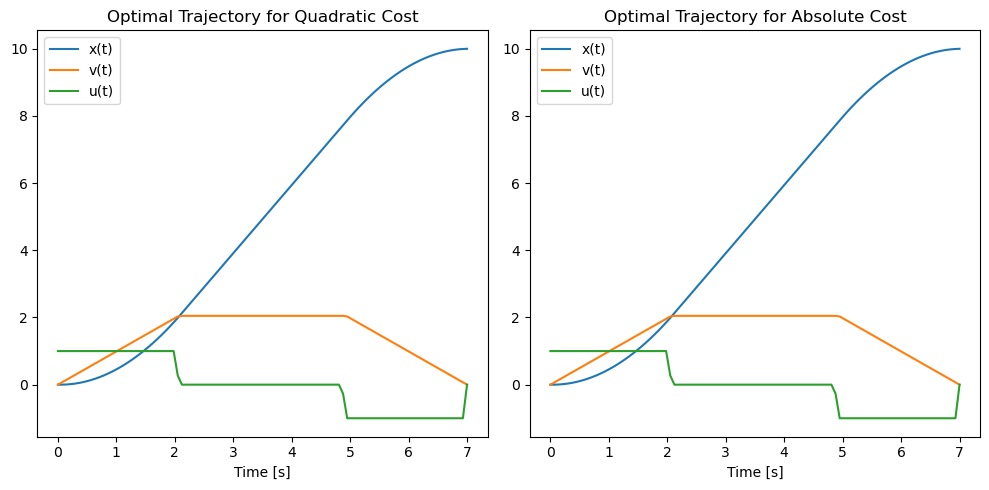

In [110]:
# Discretize time
N = 100  # Number of time steps
T = 7  # Time horizon
dt = T / N
time = np.linspace(0, T, N)
x0 = 0  # Initial position
xf = 10  # Final position
v0 = 0  # Initial velocity
vf = 0  # Final velocity

# Define the variables
x = cp.Variable(N)  # Position
v = cp.Variable(N)  # Velocity
u = cp.Variable(N)  # Control input

# Initial and terminal conditions
constraints = [
    x[0] == x0,
    v[0] == v0,
    x[-1] == xf,
    v[-1] == vf
]

# Cost functions
j1 = cp.sum_squares(u) * dt
j2 = cp.norm(u, 1) * dt

# Dynamics constraints
constraints += [
    x[1:] == x[:-1] + v[:-1] * dt,
    v[1:] == v[:-1] + u[:-1] * dt,
    cp.abs(u) <= 1
]

# Solve the problem for quadratic cost
p1 = cp.Problem(cp.Minimize(j1), constraints)
p1.solve()

# Solve the problem for absolute cost
p2 = cp.Problem(cp.Minimize(j2), constraints)
p2.solve()

print(f'Problem 1 status: {p1.status}, optimal cost: {p1.value}')
print(f'Problem 2 status: {p2.status}, optimal cost: {p2.value}')

# Extract the optimal trajectories
x_opt_1 = x.value
v_opt_1 = v.value
u_opt_1 = u.value

x_opt_2 = x.value
v_opt_2 = v.value
u_opt_2 = u.value

# Plotting the results
plt.figure(figsize=(10, 5))

# Plot for quadratic cost
plt.subplot(1, 2, 1)
plt.plot(time, x_opt_1, label='x(t)')
plt.plot(time, v_opt_1, label='v(t)')
plt.plot(time, u_opt_1, label='u(t)')
plt.title('Optimal Trajectory for Quadratic Cost')
plt.xlabel('Time [s]')
plt.legend()

# Plot for absolute cost
plt.subplot(1, 2, 2)
plt.plot(time, x_opt_2, label='x(t)')
plt.plot(time, v_opt_2, label='v(t)')
plt.plot(time, u_opt_2, label='u(t)')
plt.title('Optimal Trajectory for Absolute Cost')
plt.xlabel('Time [s]')
plt.legend()

plt.tight_layout()
plt.show()

The trajectories are similar for the two cost functions, likely due to that they share similar properties. However, they do give slightly different optimal solutions.

## Problem 2

Problem status: optimal, optimal cost: 1.4324632672391084, at iteration 0
Problem status: optimal, optimal cost: 1.432463267239397, at iteration 1
Problem status: optimal, optimal cost: 1.4324632672280404, at iteration 2
Problem status: optimal, optimal cost: 1.4324632672374698, at iteration 3
Problem status: optimal, optimal cost: 1.4324632672391102, at iteration 4
Problem status: optimal, optimal cost: 1.432463267235101, at iteration 5
Problem status: optimal, optimal cost: 1.4324632672396096, at iteration 6
Problem status: optimal, optimal cost: 1.4324632672375601, at iteration 7
Problem status: optimal, optimal cost: 1.4324632672394841, at iteration 8
Problem status: optimal, optimal cost: 1.4324632672441333, at iteration 9
Optimal cost: 1.4324632672441333


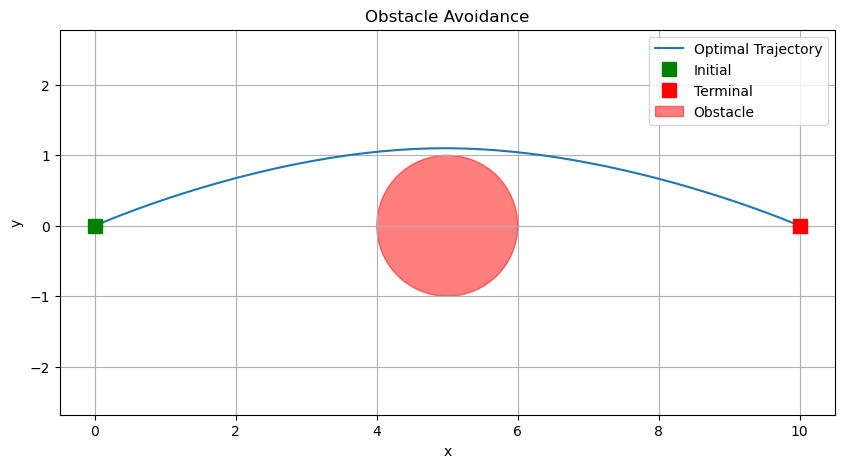

In [113]:
# Define parameters
N = 100
T = 10.0
dt = T/N
x0 = np.array([0, 0])
xf = np.array([10, 0])
v0 = np.array([0, 0])
vf = np.array([0, 0])
x_obs = np.array([5, 0])
r_obs = 1
safe_distance = 0.1
r_safe = r_obs + safe_distance
max_iter = 10

# Initialize variables for cvxpy
x = cp.Variable((N+1, 2))
v = cp.Variable((N+1, 2))
u = cp.Variable((N, 2))

# Initial guess for trajectory (straight line offset in y to avoid the obstacle)
x_init = np.linspace(x0, xf, N+1)
x_init[:, 1] += 2  # Offset in y to avoid the obstacle initially

# Define the cost function
cost = cp.sum_squares(u) * dt

# Dynamics constraints
constraints = [x[0] == x0, x[N] == xf, v[0] == v0, v[N] == vf]
for i in range(N):
    constraints += [
        x[i+1] == x[i] + dt*v[i],
        v[i+1] == v[i] + dt*u[i],
        cp.norm(u[i], 'inf') <= 1
    ]

# SCP iteration
for iter in range(max_iter):
    # Obstacle avoidance constraint (initially using the initial guess)
    for k in range(1, N):
        # Linearization around the current nominal trajectory
        x_nom = x_init[k]
        constraints += [
            (x_nom - x_obs).T @ (x[k] - x_obs) >= r_safe * cp.norm(x_nom - x_obs)
        ]

    # Solve the problem
    problem = cp.Problem(cp.Minimize(cost), constraints)
    problem.solve(solver='ECOS')
    print(f'Problem status: {problem.status}, optimal cost: {problem.value}, at iteration {iter}')

    # Update the trajectory
    x_init = x.value

# Check if the problem was solved
if problem.status in ["infeasible", "unbounded"]:
    print("The problem is infeasible or unbounded.")
else:
    print(f"Optimal cost: {problem.value}")
    optimal_trajectory = x.value

    # Plotting the results
    plt.figure(figsize=(10, 5))
    plt.plot(optimal_trajectory[:, 0], optimal_trajectory[:, 1], label='Optimal Trajectory')
    plt.plot(x0[0], x0[1], 'gs', markersize=10, label='Initial')
    plt.plot(xf[0], xf[1], 'rs', markersize=10, label='Terminal')
    
    # Plotting the obstacle
    obstacle_circle = plt.Circle(x_obs, r_obs, color='r', alpha=0.5, label='Obstacle')
    plt.gca().add_patch(obstacle_circle)
    
    plt.xlabel('x')
    plt.ylabel('y')
    plt.title('Obstacle Avoidance')
    plt.legend()
    plt.grid(True)
    plt.axis('equal')
    plt.show()

## Problem 3

In [139]:
# Define parameters
N = 100
T = 10.0
dt = T/N
x0 = np.array([0, 0])
xf = np.array([10, 0])
v0 = np.array([0, 0])
vf = np.array([0, 0])
theta0 = 0  # Initial orientation
thetaf = 0  # Final orientation
x_obs = np.array([5, 0])
r_obs = 1
safe_distance = 0.1
r_safe = r_obs + safe_distance

# Initialize variables for cvxpy
x = cp.Variable((N+1, 2))
v = cp.Variable((N+1, 2))
theta = cp.Variable(N+1)
theta_dot = cp.Variable(N+1)
u = cp.Variable((N, 2))

# Initial guess for trajectory (straight line offset in y to avoid the obstacle)
x_init = np.linspace(x0, xf, N+1)
x_init[:, 1] += 2  # Offset in y to avoid the obstacle initially
theta_init = np.linspace(theta0, thetaf, N+1)
theta_init += 1  # Offset in theta to avoid the obstacle initially
# cos_theta = np.cos(theta_init)
# sin_theta = np.sin(theta_init)

# Define the cost function
cost = cp.sum(cp.norm(u, 2, axis=0) * dt)

# Dynamics constraints
constraints = [x[0] == x0, x[N] == xf, v[0] == v0, v[N] == vf, theta[0] == theta0, theta[N] == thetaf]
for i in range(N):
    constraints += [
        x[i+1] == x[i] + dt*v[i],
        theta[i+1] == theta[i] + dt*theta_dot[i],
        theta_dot[i+1] == theta_dot[i] + dt*u[i, 1],
        cp.norm(u[i, 0], 'inf') <= 1,
        cp.norm(u[i, 1], 'inf') <= 10
    ]

# SCP iteration
for iter in range(max_iter):
    # Obstacle avoidance constraint (initially using the initial guess)
    for k in range(1, N):
        # Linearization around the current nominal trajectory
        x_nom = x_init[k]
        constraints += [
            (x_nom - x_obs).T @ (x[k] - x_obs) >= r_safe * cp.norm(x_nom - x_obs)
        ]
    
    # Theta dynamics constraint
    for k in range(1, N):
        # Linearization around the current nominal trajectory
        theta_nom = theta_init[k]
        # dx = cos_theta[i] - sin_theta[i]*(theta[i] - theta_init[i])
        # dy = sin_theta[i] + cos_theta[i]*(theta[i] - theta_init[i])
        dv = [np.cos(theta_nom), np.sin(theta_nom)]
        constraints += [
            (x_nom - x_obs).T @ (x[k] - x_obs) >= r_safe * cp.norm(x_nom - x_obs),
            v[i+1, 0] == v[i, 0] + dt * u[i, 0] * dv[0],
            v[i+1, 1] == v[i, 1] + dt * u[i, 0] * dv[1]
        ]

    # Solve the problem
    problem = cp.Problem(cp.Minimize(cost), constraints)
    problem.solve(solver='ECOS')
    print(f'Problem status: {problem.status}, optimal cost: {problem.value}, at iteration {iter}')

    # Update the trajectory
    x_init = x.value
    theta_init = theta.value
    # cos_theta = np.cos(theta_init)
    # sin_theta = np.sin(theta_init)
    

# Check if the problem was solved
if problem.status in ["infeasible", "unbounded"]:
    print("The problem is infeasible or unbounded.")
else:
    print(f"Optimal cost: {problem.value}")
    optimal_trajectory = x.value

    # Plotting the results
    plt.figure(figsize=(10, 5))
    plt.plot(optimal_trajectory[:, 0], optimal_trajectory[:, 1], label='Optimal Trajectory')
    plt.plot(x0[0], x0[1], 'gs', markersize=10, label='Initial')
    plt.plot(xf[0], xf[1], 'rs', markersize=10, label='Terminal')
    
    # Plotting the obstacle
    obstacle_circle = plt.Circle(x_obs, r_obs, color='r', alpha=0.5, label='Obstacle')
    plt.gca().add_patch(obstacle_circle)
    
    plt.xlabel('x')
    plt.ylabel('y')
    plt.title('Obstacle Avoidance')
    plt.legend()
    plt.grid(True)
    plt.axis('equal')
    plt.show()

Problem status: infeasible, optimal cost: inf, at iteration 0


TypeError: 'NoneType' object is not subscriptable

## Problem 4

In [140]:
# Define parameters
N = 100
T = 10.0
dt = T/N

x0 = np.array([0, 0])
xf = np.array([10, 0])
v0 = np.array([0, 0])
vf = np.array([0, 0])
theta0 = 0  # Initial orientation
thetaf = 0  # Final orientation

x0_2 = np.array([0, -2])
xf_2 = np.array([10, 0])
v0_2 = np.array([0, 0])
vf_2 = np.array([0, 0])
theta0_2 = 0  # Initial orientation
thetaf_2 = 0  # Final orientation

x_obs = np.array([5, 0])
r_obs = 1
safe_distance = 0.1
r_safe = r_obs + safe_distance

# Initialize variables for cvxpy
x = cp.Variable((N+1, 2))
v = cp.Variable((N+1, 2))
theta = cp.Variable(N+1)
theta_dot = cp.Variable(N+1)
u = cp.Variable((N, 2))

x_2 = cp.Variable((N+1, 2))
v_2 = cp.Variable((N+1, 2))
theta_2 = cp.Variable(N+1)
theta_dot_2 = cp.Variable(N+1)
u_2 = cp.Variable((N, 2))

# Initial guess for trajectory (straight line offset in y to avoid the obstacle)
x_init = np.linspace(x0, xf, N+1)
x_init[:, 1] += 2  # Offset in y to avoid the obstacle initially
theta_init = np.linspace(theta0, thetaf, N+1)
theta_init += 1  # Offset in theta to avoid the obstacle initially
# cos_theta = np.cos(theta_init)
# sin_theta = np.sin(theta_init)

x_init_2 = np.linspace(x0_2, xf_2, N+1)
x_init_2[:, 1] += 2  # Offset in y to avoid the obstacle initially
theta_init_2 = np.linspace(theta0_2, thetaf_2, N+1)
theta_init_2 += 1  # Offset in theta to avoid the obstacle initially

# Define the cost function
cost = cp.sum(cp.norm(u, 2, axis=0) * dt) + cp.sum(cp.norm(u_2, 2, axis=0) * dt)

# Dynamics constraints
constraints = [x[0] == x0, x[N] == xf, v[0] == v0, v[N] == vf, theta[0] == theta0, theta[N] == thetaf]
constraints += [x_2[0] == x0_2, x_2[N] == xf_2, v_2[0] == v0_2, v_2[N] == vf_2, theta_2[0] == theta0_2, theta_2[N] == thetaf_2]
for i in range(N):
    constraints += [
        x[i+1] == x[i] + dt*v[i],
        theta[i+1] == theta[i] + dt*theta_dot[i],
        theta_dot[i+1] == theta_dot[i] + dt*u[i, 1],
        cp.norm(u[i, 0], 'inf') <= 1,
        cp.norm(u[i, 1], 'inf') <= 10,
        x_2[i+1] == x_2[i] + dt*v_2[i],
        theta_2[i+1] == theta_2[i] + dt*theta_dot_2[i],
        theta_dot_2[i+1] == theta_dot_2[i] + dt*u_2[i, 1],
        cp.norm(u_2[i, 0], 'inf') <= 1,
        cp.norm(u_2[i, 1], 'inf') <= 10
        x[i] != x_2[i] # Collision avoidance constraint
    ]

# SCP iteration
for iter in range(max_iter):
    # Obstacle avoidance constraint (initially using the initial guess)
    for k in range(1, N):
        # Linearization around the current nominal trajectory
        x_nom = x_init[k]
        x_nom_2 = x_init_2[k]
        constraints += [
            (x_nom - x_obs).T @ (x[k] - x_obs) >= r_safe * cp.norm(x_nom - x_obs)
            (x_nom_2 - x_obs).T @ (x_2[k] - x_obs) >= r_safe * cp.norm(x_nom_2 - x_obs)
        ]
    
    # Theta dynamics constraint
    for k in range(1, N):
        # Linearization around the current nominal trajectory
        theta_nom = theta_init[k]
        theta_nom_2 = theta_init_2[k]
        # dx = cos_theta[i] - sin_theta[i]*(theta[i] - theta_init[i])
        # dy = sin_theta[i] + cos_theta[i]*(theta[i] - theta_init[i])
        dv = [np.cos(theta_nom), np.sin(theta_nom)]
        dv_2 = [np.cos(theta_nom_2), np.sin(theta_nom_2)]
        constraints += [
            (x_nom - x_obs).T @ (x[k] - x_obs) >= r_safe * cp.norm(x_nom - x_obs),
            v[i+1, 0] == v[i, 0] + dt * u[i, 0] * dv[0],
            v[i+1, 1] == v[i, 1] + dt * u[i, 0] * dv[1],
            (x_nom_2 - x_obs).T @ (x_2[k] - x_obs) >= r_safe * cp.norm(x_nom_2 - x_obs),
            v_2[i+1, 0] == v_2[i, 0] + dt * u_2[i, 0] * dv_2[0],
            v_2[i+1, 1] == v_2[i, 1] + dt * u_2[i, 0] * dv_2[1]
        ]

    # Solve the problem
    problem = cp.Problem(cp.Minimize(cost), constraints)
    problem.solve(solver='ECOS')
    print(f'Problem status: {problem.status}, optimal cost: {problem.value}, at iteration {iter}')

    # Update the trajectory
    x_init = x.value
    theta_init = theta.value
    # cos_theta = np.cos(theta_init)
    # sin_theta = np.sin(theta_init)
    

# Check if the problem was solved
if problem.status in ["infeasible", "unbounded"]:
    print("The problem is infeasible or unbounded.")
else:
    print(f"Optimal cost: {problem.value}")
    optimal_trajectory = x.value
    optimal_trajectory_2 = x_2.value

    # Plotting the results
    plt.figure(figsize=(10, 5))
    plt.plot(optimal_trajectory[:, 0], optimal_trajectory[:, 1], label='Optimal Trajectory')
    plt.plot(optimal_trajectory_2[:, 0], optimal_trajectory_2[:, 1], label='Optimal Trajectory 2')
    plt.plot(x0[0], x0[1], 'gs', markersize=10, label='Initial')
    plt.plot(xf[0], xf[1], 'rs', markersize=10, label='Terminal')
    
    # Plotting the obstacle
    obstacle_circle = plt.Circle(x_obs, r_obs, color='r', alpha=0.5, label='Obstacle')
    plt.gca().add_patch(obstacle_circle)
    
    plt.xlabel('x')
    plt.ylabel('y')
    plt.title('Obstacle Avoidance')
    plt.legend()
    plt.grid(True)
    plt.axis('equal')
    plt.show()

SyntaxError: invalid syntax (3244326900.py, line 69)

## Problem 5

Ensuring that the problem is strongly convex within the trust region can contribute to a faster rate of convergence. If we use a quadratic model within the trust region that has a positive definite Hessian, this could potentially provide a sharper convergence rate within the region, as the quadratic approximation may be good enough to capture the curvature of the actual function.